<h2>For this round I have decided to build a stock prediction model which forecast the 'Close' feature of reliance's history data</h2>
<h1>Dataset Description</h1>
<p>There are multiple variables in the dataset – date, open, high, low, last, close, total_trade_quantity, and turnover.
    <li>
    The columns Open and Close represent the starting and final price at which the stock is traded on a particular day.
    </li>
    <li>
    High, Low and Last represent the maximum, minimum, and last price of the share for the day.
    </li>
    <li>
    Total Trade Quantity is the number of shares bought or sold in the day and Turnover (Lacs) is the turnover of the particular company on a given date.
    </li>
</p>


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
Using Theano backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,8

In [3]:
import datetime

In [4]:
reliance = pd.read_csv('https://www.quandl.com/api/v3/datasets/NSE/TATAGLOBAL.csv?api_key=YHzyzmYBB1zjEgSiEYxQ')

In [5]:
reliance.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09


In [6]:
reliance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 8 columns):
Date                    2100 non-null object
Open                    2100 non-null float64
High                    2100 non-null float64
Low                     2100 non-null float64
Last                    2100 non-null float64
Close                   2100 non-null float64
Total Trade Quantity    2100 non-null float64
Turnover (Lacs)         2100 non-null float64
dtypes: float64(7), object(1)
memory usage: 131.4+ KB


In [7]:
reliance['Date'] = pd.to_datetime(reliance.Date,format='%Y-%m-%d')
reliance.index = reliance['Date']
# reliance.drop('Date', axis=1, inplace=True)

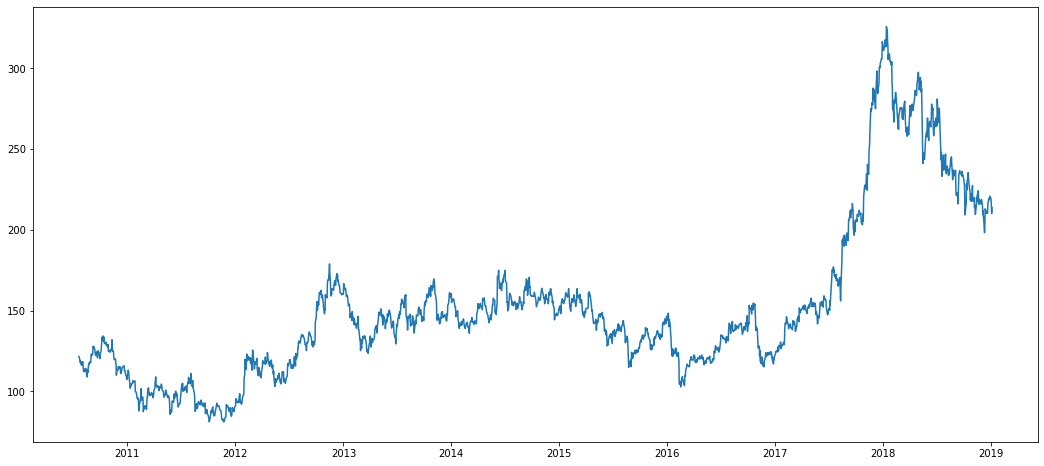

In [8]:
plt.plot(reliance['Close'], label='Close Price history');

In [10]:
reliance['Close'].idxmax()

Timestamp('2018-01-12 00:00:00')

<p>We can have a look at the Intraday reports for Reliance Industries from the link below</p>
<a>https://www.outlookindia.com/outlookmoney/stockmarket/reliance-industries-ltd-reliance-500325/2018-01-12</a>

<h1>Candle Stick Plot</h1>

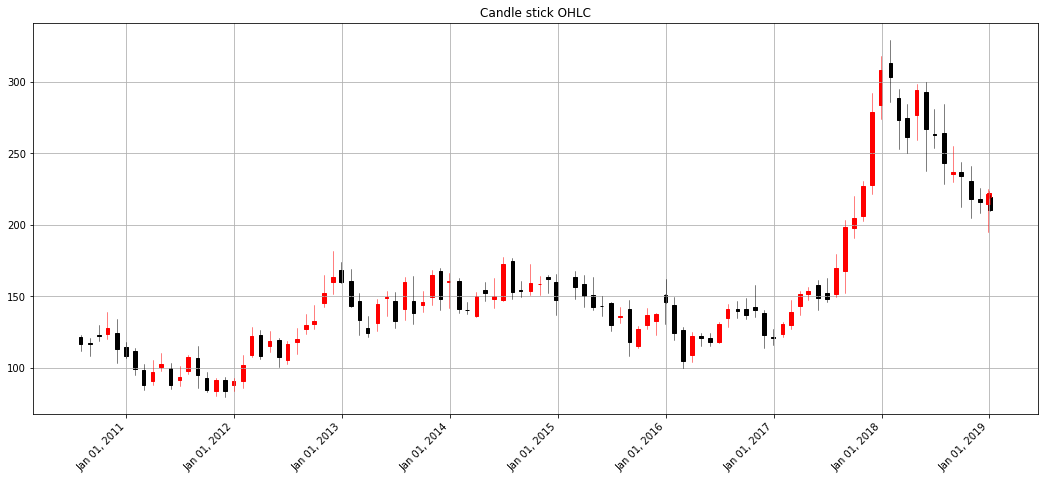

In [9]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from mpl_finance import candlestick_ohlc
from matplotlib.dates import date2num
 
def pandas_candlestick_ohlc(dat, stick = "day", adj = False, otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param adj: A boolean indicating whether to use adjusted prices
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    fields = ["Open", "High", "Low", "Close"]
    if adj:
        fields = ["Adj. " + s for s in fields]
    transdat = dat.loc[:,fields]
    transdat.columns = pd.Index(["Open", "High", "Low", "Close"])
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.title('Candle stick OHLC')
    
    plt.show()
 
pandas_candlestick_ohlc(reliance, adj=False, stick="month")

<h1>Candlestick chart</h1>
<p>With a candlestick chart, a black candlestick indicates a day where the closing price was higher than the open (a gain), while a red candlestick indicates a day where the open was higher than the close (a loss). The wicks indicate the high and the low, and the body the open and close (hue is used to determine which end of the body is the open and which the close). </p>

In [23]:
# splitting into train and validation
def train_valid_split(data):
   data = data.sort_index(ascending=True, axis=0)
   new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])
     
   for i in range(0,len(reliance)):
      try:
         new_data['Date'][i] = data['Date'][i]
         new_data['Close'][i] = data['Close'][i]
      except KeyError:
         new_data['Close'][i] = data['Close'][i]
   train = new_data[:(int(len(data)*0.8))]
   valid = new_data[(int(len(data)*0.8)):]
   #  # shapes of training set
   #  print('\n Shape of training set:')
   #  print(train.shape)

   #  # shapes of validation set
   #  print('\n Sha  pe of validation set:')
   #  print(valid.shape)
   
   
   return train,valid

In [24]:
reliance

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2019-01-04,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
2019-01-03,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2019-01-02,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
2019-01-01,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
2018-12-31,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09
...,...,...,...,...,...,...,...,...
2010-07-27,2010-07-27,117.60,119.50,112.00,118.80,118.65,586100.0,694.98
2010-07-26,2010-07-26,120.10,121.00,117.10,117.10,117.60,658440.0,780.01
2010-07-23,2010-07-23,121.80,121.95,120.25,120.35,120.65,281312.0,340.31



 RMSE value on validation set using custom prediction:
94.75022144360904


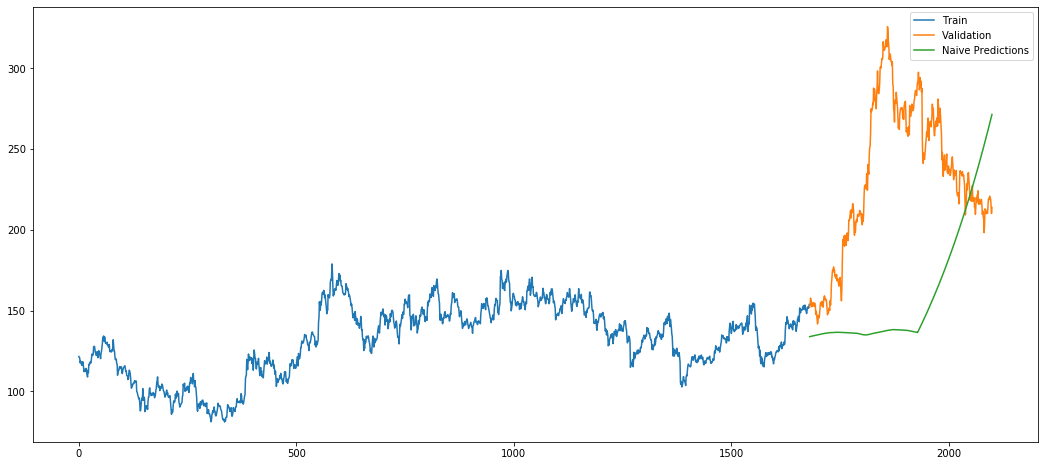

In [25]:
def moving_average(data):
    #prediction using moving average method
    train,valid =  train_valid_split(data)
    preds = []
    for i in range(0,valid.shape[0]):
        a = train['Close'][len(train)-248+i:].sum() + sum(preds)
        b = a/248
        preds.append(b)

    # checking the results (RMSE value)
    rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
    print('\n RMSE value on validation set using custom prediction:')
    print(rms)
    
    valid['Predictions'] = 0
    valid['Predictions'] = preds

    plt.plot(train['Close'],label='Train')
    plt.plot(valid['Close'],label = 'Validation')
    plt.plot(valid['Predictions'],label = 'Naive Predictions')
    plt.legend();
moving_average(reliance)


<h1>Auto Arima</h1>

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7988.364, BIC=8015.458, Fit time=7.824 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9141.116, BIC=9151.954, Fit time=0.091 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=8674.173, BIC=8695.848, Fit time=1.420 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7986.480, BIC=8008.155, Fit time=5.173 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9139.123, BIC=9144.542, Fit time=0.062 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=9145.106, BIC=9166.781, Fit time=0.519 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=7988.506, BIC=8021.019, Fit time=5.253 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at 

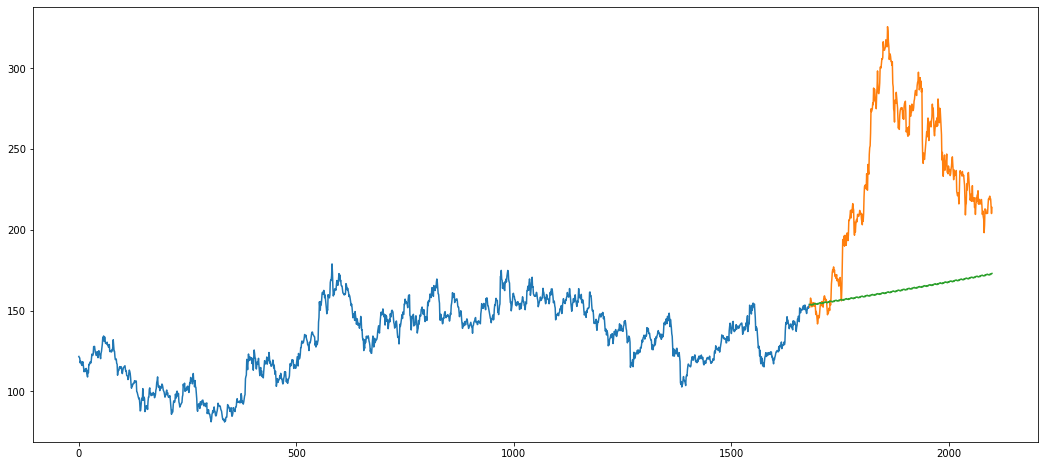

In [34]:

def auto_arima_pred(data):
    #returns prediction using arima model
    train,valid =  train_valid_split(reliance)
    training = train['Close']
    validation = valid['Close']

    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)

    forecast = model.predict(n_periods=420)
    forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])
    rms_autoarima=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
    print('\n RMSE value on validation set using auto arima:')
    print(rms_autoarima)
    plt.plot(train['Close'])
    plt.plot(valid['Close'])
    plt.plot(forecast['Prediction'],label = 'Auto Arima')

auto_arima_pred(reliance)    

<h2>Inference</h2>
<p>Even though the prediction is better we can observe it doesnt take care of the seasonality<p>

<h1>Prophets Prediction</h1>

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

 RMSE value on validation set using facebook prophet:
95.65287482447319


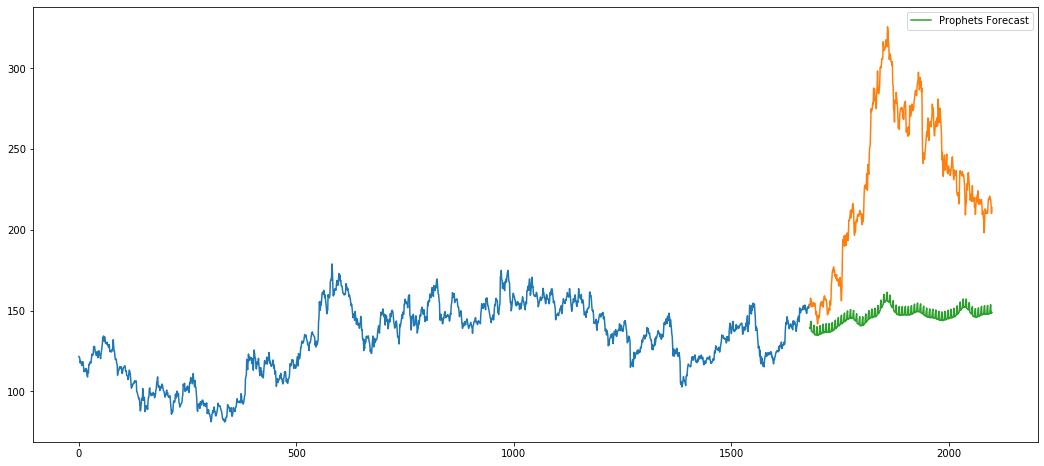

In [38]:
def prophets_prediction(data):
    #return predictions using facebooks prophet library

    #creating dataframe
    new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])

    for i in range(0,len(reliance)):
        new_data['Date'][i] = data['Date'][i]
        new_data['Close'][i] = data['Close'][i]

    new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
    new_data.index = new_data['Date']

    #preparing data
    #new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)
    def renaming_columns(data):
        return(data.rename(columns={'Close': 'y', 'Date': 'ds'}))

    #train and validation
    train,valid = train_valid_split(data)

    train = renaming_columns(train)
    valid = renaming_columns(valid)

    

    #fit the model
    model = Prophet()
    model.fit(train)

    #predictions
    close_prices = model.make_future_dataframe(periods=len(valid))
    forecast = model.predict(close_prices)

    forecast_valid = forecast['yhat'][(int(len(data)*0.8)):]
    
    rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
    print('\n RMSE value on validation set using facebook prophet:')
    print(rms)

    #plot
    valid['Predictions'] = 0
    valid['Predictions'] = forecast_valid.values

    plt.plot(train['y'])
    plt.plot(valid['y']);
    plt.plot(valid['Predictions'],label = 'Prophets Forecast')
    plt.legend()


prophets_prediction(reliance)


<h1>LSTM </h1>

In [28]:
def LSTM_prediction(data):
    #uses lstm model with 50 units
    train,valid = train_valid_split(data)
    new_data = pd.concat([train, valid], ignore_index=False)
    new_data.index = new_data.Date
    new_data.drop('Date', axis=1, inplace=True)
    dataset = new_data.values

    train,valid = train_valid_split(new_data)

    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60,len(train)):
        x_train.append(scaled_data[i-60:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    # predicting 246 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)

    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((np.array(valid.Close)-closing_price),2)))
    print('\n RMSE value on validation set using LSTM:')
    print(rms)
    valid['Predictions'] = closing_price
    plt.plot(train['Close'])
    plt.plot(valid['Close'])
    plt.plot(valid['Predictions'],label='LSTM' )
    plt.legend()
    plt.show()


    

Epoch 1/1
 - 13s - loss: 6.9443e-04

 RMSE value on validation set using LSTM:
63.26118656162113


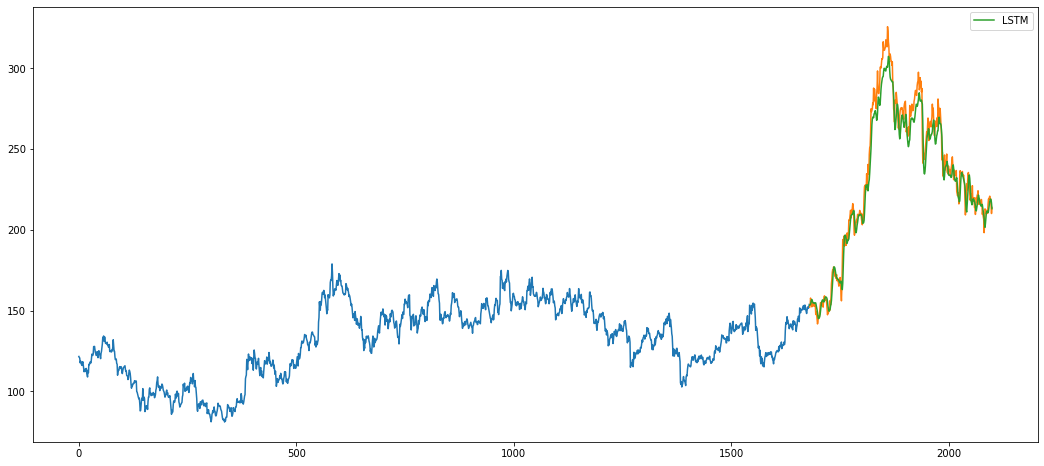

In [29]:
LSTM_prediction(reliance)


 RMSE value on validation set using custom prediction:
94.75022144360904
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7988.364, BIC=8015.458, Fit time=6.792 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9141.116, BIC=9151.954, Fit time=0.090 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=8674.173, BIC=8695.848, Fit time=1.373 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7986.480, BIC=8008.155, Fit time=4.850 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=9139.123, BIC=9144.542, Fit time=0.066 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=9145.106, BIC=9166.781, Fit time=0.475 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=7988.506, BIC=8021.019, Fit time=4.600 seconds
Near non-in

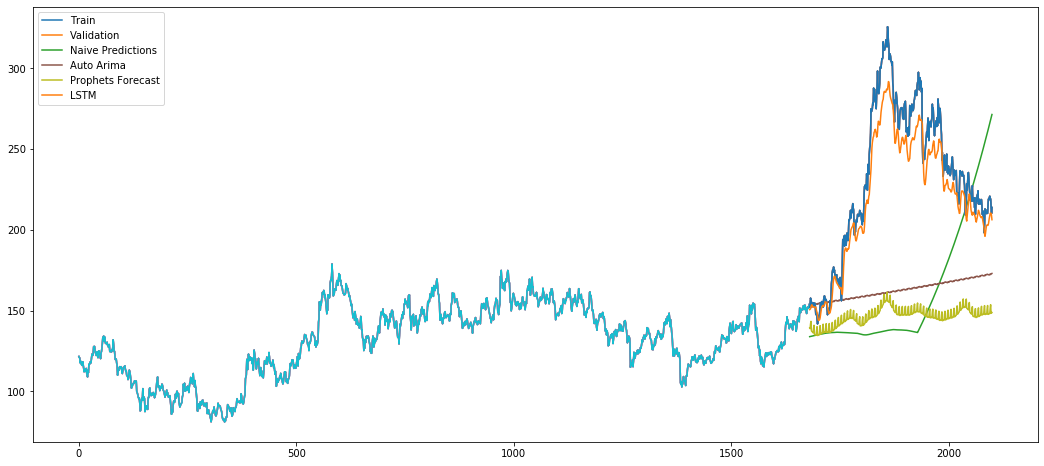

In [37]:
moving_average(reliance)
auto_arima_pred(reliance)
prophets_prediction(reliance)
LSTM_prediction(reliance)



<html>
<head>
<style>
table, th, td {
  border: 1px solid black;
  border-collapse: collapse;
}
th, td {
  padding: 5px;
  text-align: left;
}
</style>
</head>
<body>

<h2>Performance Comparison</h2>
<p>Based on RMSE values.</p>

<table style="width:100%">
  
  <tr>
    <th>Model</th>
    <th>RMSE score</th>
  </tr>
  <tr>
    <td>Moving average</td>
    <td>94.7502</td>
  </tr>
  <tr>
    <td>Auto Arima</td>
    <td>82.4454</td>
  </tr>
  <tr>
    <td>Arima using fb prophet</td>
    <td>95.65287482447319</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td>61.65415352257374</td>
  </tr>
</table>
<h2>Conclusion</h2>
<p><b><i> LSTM has the best performance.</i></b></p>
</body>
</html>